# Imports

In [1]:
import sys
print(sys.version)

3.9.5 (default, Jan  2 2022, 22:23:27) 
[GCC 11.1.0]


In [7]:
import numpy as np
import pandas as pd
import regex as re
import string

import torch
import torch.nn as nn

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Constants and helpers

In [8]:
target_names = ['legitimate','misinformation','irrelevant']
max_length = 96
stop = stopwords.words('english')

In [9]:
def clean_text(row):
    # Lower case
    row = row.lower()
    
    # Remove URLs
    row = re.sub('http\S+|www.\S+', '', row)
    
    # Remove @mentions
    row = re.sub('@[A-Za-z0-9]+', '', row)
    
    # Remove non-standard characters
    row = row.encode("ascii", "ignore").decode()
    
    # Remove punctuation
    row = row.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    pat = r'\b(?:{})\b'.format('|'.join(stop))
    row = row.replace(pat, '')
    row = row.replace(r'\s+', ' ')
    
    # Remove extraneous whitespace
    row = row.strip()
    
    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    w_tokenization = nltk.word_tokenize(row)
    final = ""
    for w in w_tokenization:
        final = final + " " + wordnet_lemmatizer.lemmatize(w)
    
    return final

# Model

In [10]:
PATH1 = 'models/first-augmented-miscov19-covid-twitter-bert-v2'
tokenizer1 = AutoTokenizer.from_pretrained(PATH1, local_files_only=True)
model1 = AutoModelForSequenceClassification \
        .from_pretrained(PATH1, num_labels=len(target_names), local_files_only=True).to("cuda")

PATH2 = 'models/second-augmented-miscov19-covid-twitter-bert-v2'
tokenizer2 = AutoTokenizer.from_pretrained(PATH2, local_files_only=True)
model2 = AutoModelForSequenceClassification \
        .from_pretrained(PATH2, num_labels=len(target_names), local_files_only=True).to("cuda")

PATH3 = 'models/third-augmented-miscov19-covid-twitter-bert-v2'
tokenizer3 = AutoTokenizer.from_pretrained(PATH3, local_files_only=True)
model3 = AutoModelForSequenceClassification \
        .from_pretrained(PATH3, num_labels=len(target_names), local_files_only=True).to("cuda")

PATH4 = 'models/fourth-augmented-miscov19-covid-twitter-bert-v2'
tokenizer4 = AutoTokenizer.from_pretrained(PATH4, local_files_only=True)
model4 = AutoModelForSequenceClassification \
        .from_pretrained(PATH4, num_labels=len(target_names), local_files_only=True).to("cuda")


In [11]:
class BaggedTweetClassifier(nn.Module):
    def __init__(self):
        super(BaggedTweetClassifier, self).__init__()
        self.tok1 = tokenizer1
        self.bert1 = model1
        
        self.tok2 = tokenizer2
        self.bert2 = model2
        
        self.tok3 = tokenizer3
        self.bert3 = model3
        
        self.tok4 = tokenizer4
        self.bert4 = model4

    def forward(self, x, debug=False):
        x = clean_text(x)
        
        in1 = self.tok1(x, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
        in2 = self.tok2(x, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
        in3 = self.tok3(x, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
        in4 = self.tok4(x, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
        
        out1 = self.bert1(**in1)
        out2 = self.bert2(**in2)
        out3 = self.bert3(**in3)
        out4 = self.bert4(**in4)
        
        probs1 = out1[0].softmax(1)
        probs2 = out2[0].softmax(1)
        probs3 = out3[0].softmax(1)
        probs4 = out4[0].softmax(1)
        
        avg_prob = (probs1 + probs2 + probs3 + probs4) / 4.0
        
        if(debug):
            print(f'-------------------------------------------------------------')
            print(f'| label        | model1 | model2 | model3 | model4 | avg_pr |')
            print(f'| legitimate   | {probs1[0][0].item():.4f} | {probs2[0][0].item():.4f} | {probs3[0][0].item():.4f} | {probs4[0][0].item():.4f} | {avg_prob[0][0].item():.4f} |')
            print(f'| misinfo      | {probs1[0][1].item():.4f} | {probs2[0][1].item():.4f} | {probs3[0][1].item():.4f} | {probs4[0][1].item():.4f} | {avg_prob[0][1].item():.4f} |')
            print(f'| irrelevant   | {probs1[0][2].item():.4f} | {probs2[0][2].item():.4f} | {probs3[0][2].item():.4f} | {probs4[0][2].item():.4f} | {avg_prob[0][2].item():.4f} |')
            print(f'-------------------------------------------------------------')
            return target_names[avg_prob.argmax()]
        
        return avg_prob.argmax()
    

In [12]:
model = BaggedTweetClassifier()

### Accuracy and Confusion Matrix on MisCov19 Dataset

In [13]:
raw_df = pd.read_csv('miscov19_augmented_final.csv')
df = raw_df[['text','label']]
df.dropna()
df['text'] = df['text'].astype(str)
df.tail()

,text,label
4568,Da fark is wrong with these people?!\n\nhttps:...,0
4569,Doctor Finds Cure to COVID-19 (without Vaccine...,1
4570,I can’t believe people legitimately think that...,0
4571,"...(wrong with Trump continues), \n-Will push ...",2
4572,For anyone who still believes that COVID-19 is...,0


In [14]:
df['text'] = df['text'].apply(clean_text)

In [15]:
df['preds'] = df['text'].apply(model)

In [16]:
def to_cpu(x):
    return x.cpu()

In [17]:
df['preds'] = df['preds'].apply(to_cpu)

In [19]:
y_true = df['label'].tolist()
y_pred = df['preds'].tolist()

In [20]:
print(f'Ensemble Accuracy: {accuracy_score(y_true, y_pred)}')

Ensemble Accuracy: 0.8381806254100153


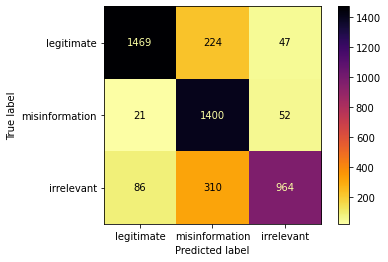

In [21]:
confusion_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=target_names)
disp.plot(cmap='inferno_r')
plt.show()

### Accuracy and Confusion Matrix on Augmented MisCov19 Dataset

In [22]:
raw_df = pd.read_csv('combined_data.csv')
df = raw_df[['text','label']]
df.dropna()
df['text'] = df['text'].astype(str)
df.tail()

,text,label
6572,nan,1
6573,Why is everyone pretending like theyre immune ...,0
6574,CDC said if you snort enough cocaine it would ...,2
6575,A message hailing the powers of 'boiled garlic...,0
6576,5G Networks? Bleach? Ultraviolet light? The co...,0


In [23]:
df['text'] = df['text'].apply(clean_text)

In [24]:
df['preds'] = df['text'].apply(model)

In [25]:
df['preds'] = df['preds'].apply(to_cpu)

In [26]:
y_true2 = df['label'].tolist()
y_pred2 = df['preds'].tolist()

In [27]:
print(f'Ensemble Accuracy (Augmented): {accuracy_score(y_true2, y_pred2)}')

Ensemble Accuracy (Augmented): 0.8759312756575947


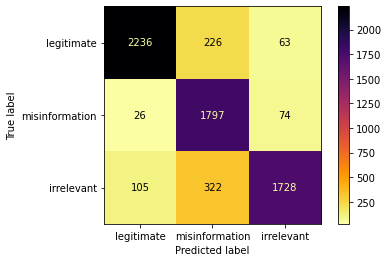

In [28]:
confusion_mat2 = confusion_matrix(y_true2, y_pred2)
disp2 = ConfusionMatrixDisplay(confusion_mat2, display_labels=target_names)
disp2.plot(cmap='inferno_r')
plt.show()

### Cherry picked examples

In [29]:
# Example #1
text = "DP Dough is the best restaurant in New York"
print(model(text, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0074 | 0.0233 | 0.0101 | 0.0164 | 0.0143 |
| misinfo      | 0.0112 | 0.0304 | 0.0078 | 0.0263 | 0.0189 |
| irrelevant   | 0.9814 | 0.9463 | 0.9821 | 0.9572 | 0.9668 |
-------------------------------------------------------------
irrelevant


In [30]:
# Example #2
text2 = "Vaccines cause autism"
print(model(text2, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0227 | 0.0064 | 0.0027 | 0.0084 | 0.0101 |
| misinfo      | 0.9428 | 0.9777 | 0.9914 | 0.9803 | 0.9731 |
| irrelevant   | 0.0346 | 0.0159 | 0.0059 | 0.0113 | 0.0169 |
-------------------------------------------------------------
misinformation


In [31]:
# Example #3
text3 = "Vaccines prevent over 90% of Covid infections! #Science"
print(model(text3, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0022 | 0.0119 | 0.0020 | 0.0029 | 0.0048 |
| misinfo      | 0.9948 | 0.9714 | 0.9953 | 0.9923 | 0.9884 |
| irrelevant   | 0.0030 | 0.0166 | 0.0027 | 0.0048 | 0.0068 |
-------------------------------------------------------------
misinformation


In [32]:
# Example #4
text4 = "Vaccines will end the pandemic"
print(model(text4, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0242 | 0.0508 | 0.0623 | 0.0106 | 0.0370 |
| misinfo      | 0.9017 | 0.8920 | 0.8995 | 0.9823 | 0.9189 |
| irrelevant   | 0.0741 | 0.0571 | 0.0382 | 0.0071 | 0.0441 |
-------------------------------------------------------------
misinformation


In [33]:
# Example #5
text5 = "scientists say bleach will prevent covid"
print(model(text5, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0138 | 0.0575 | 0.0386 | 0.0014 | 0.0278 |
| misinfo      | 0.6240 | 0.4259 | 0.4150 | 0.9833 | 0.6120 |
| irrelevant   | 0.3621 | 0.5166 | 0.5464 | 0.0153 | 0.3601 |
-------------------------------------------------------------
misinformation


In [34]:
# Example #6
text6 = "Biden says vaccines prevent over 90% of Covid infections!"
print(model(text6, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0139 | 0.0154 | 0.0030 | 0.4809 | 0.1283 |
| misinfo      | 0.0063 | 0.0607 | 0.0010 | 0.0080 | 0.0190 |
| irrelevant   | 0.9798 | 0.9240 | 0.9959 | 0.5111 | 0.8527 |
-------------------------------------------------------------
irrelevant


In [35]:
# Example #7
text7 = "Biden says vaccines cause autism!"
print(model(text7, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0035 | 0.0148 | 0.0012 | 0.0094 | 0.0073 |
| misinfo      | 0.0045 | 0.0414 | 0.0011 | 0.0324 | 0.0198 |
| irrelevant   | 0.9919 | 0.9438 | 0.9977 | 0.9582 | 0.9729 |
-------------------------------------------------------------
irrelevant


In [36]:
# Example #8
text8 = "In Portugal, with 89% of the total population fully vaccinated, almost 90% of UCI Covid patients are unvaccinated"
print(model(text8, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.8882 | 0.0075 | 0.0438 | 0.0432 | 0.2457 |
| misinfo      | 0.1072 | 0.9789 | 0.9483 | 0.9511 | 0.7464 |
| irrelevant   | 0.0046 | 0.0137 | 0.0079 | 0.0057 | 0.0079 |
-------------------------------------------------------------
misinformation


In [37]:
# Example #9
text9 = "President Trump has covid"
print(model(text9, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0029 | 0.0103 | 0.0037 | 0.0052 | 0.0055 |
| misinfo      | 0.0070 | 0.0306 | 0.0037 | 0.0166 | 0.0145 |
| irrelevant   | 0.9901 | 0.9591 | 0.9926 | 0.9782 | 0.9800 |
-------------------------------------------------------------
irrelevant


In [38]:
# Example #10
text10 = "Vaccines don't stop you from getting covid."
print(model(text10, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.9912 | 0.9921 | 0.9752 | 0.8498 | 0.9521 |
| misinfo      | 0.0017 | 0.0034 | 0.0075 | 0.1393 | 0.0380 |
| irrelevant   | 0.0071 | 0.0046 | 0.0173 | 0.0108 | 0.0099 |
-------------------------------------------------------------
legitimate


In [39]:
# Example #11
text11 = "Vaccinations stop you from getting covid."
print(model(text11, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.4607 | 0.0404 | 0.0207 | 0.0225 | 0.1361 |
| misinfo      | 0.5273 | 0.9286 | 0.9740 | 0.9735 | 0.8509 |
| irrelevant   | 0.0120 | 0.0310 | 0.0053 | 0.0040 | 0.0131 |
-------------------------------------------------------------
misinformation


In [40]:
# Example #12
text12 = "Masks are effective"
print(model(text12, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.9930 | 0.4967 | 0.9806 | 0.5681 | 0.7596 |
| misinfo      | 0.0031 | 0.3976 | 0.0050 | 0.3626 | 0.1921 |
| irrelevant   | 0.0039 | 0.1057 | 0.0144 | 0.0693 | 0.0483 |
-------------------------------------------------------------
legitimate


In [41]:
# Example #13
text13 = "Vaccines are effective"
print(model(text13, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.8264 | 0.1046 | 0.9588 | 0.4303 | 0.5800 |
| misinfo      | 0.1372 | 0.8472 | 0.0199 | 0.5264 | 0.3827 |
| irrelevant   | 0.0365 | 0.0481 | 0.0213 | 0.0433 | 0.0373 |
-------------------------------------------------------------
legitimate


In [42]:
# Example #14
text14 = "Essential oils are effective"
print(model(text14, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.0024 | 0.0162 | 0.0033 | 0.0018 | 0.0059 |
| misinfo      | 0.9922 | 0.9528 | 0.9869 | 0.9935 | 0.9813 |
| irrelevant   | 0.0054 | 0.0310 | 0.0099 | 0.0048 | 0.0128 |
-------------------------------------------------------------
misinformation


In [43]:
# Example #15
text15 = '''The Omicron variant of the coronavirus is causing Covid-19 cases to spike, 
            with an average of more than 747,000 new cases a day, according to the latest 
            numbers from Johns Hopkins University'''
print(model(text15, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.9990 | 0.9864 | 0.9965 | 0.9982 | 0.9950 |
| misinfo      | 0.0004 | 0.0087 | 0.0017 | 0.0006 | 0.0029 |
| irrelevant   | 0.0006 | 0.0049 | 0.0018 | 0.0012 | 0.0021 |
-------------------------------------------------------------
legitimate


In [44]:
# Example #16
text16 = '''Kim Kramer has heart failure, which puts her at higher risk of having a severe case 
            of Covid-19.'''
print(model(text16, debug=True))

-------------------------------------------------------------
| label        | model1 | model2 | model3 | model4 | avg_pr |
| legitimate   | 0.9994 | 0.9962 | 0.9975 | 0.9980 | 0.9978 |
| misinfo      | 0.0004 | 0.0017 | 0.0008 | 0.0003 | 0.0008 |
| irrelevant   | 0.0003 | 0.0021 | 0.0017 | 0.0017 | 0.0014 |
-------------------------------------------------------------
legitimate
